## Dog Vs Cat: A CNN based Dog/Cat Classifer 

# enviroment setup

In [1]:
import numpy as np
import os
import glob
import cv2
from collections import Counter
import random
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dropout, ELU
from keras.layers.convolutional import Cropping2D, Convolution2D, MaxPooling2D
from keras.layers.core import Lambda, Dense, Activation, Flatten


import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 5.0)

TRAIN_DATA_PATH_LIST = ["./train"]
TEST_DATA_PATH_LIST = ["./test"]

LABEL_LIST = ["dog", "cat"]

Using TensorFlow backend.


# load and processing data

In [2]:
def load_data(DATA_PATH, LABEL_LIST):
    labels = LABEL_LIST
    labeled_data = {}
    for dir in DATA_PATH: 
        print("processing data from: " + dir)
        for key in labels:           
            labeled_data[key] = [file for file in glob.glob(os.path.join(dir, key + '*.jpg'))]
            print("total " + str(len(labeled_data[key])) + " " + key + " images found.")
        
    return labeled_data


def raw_data_analysis(data):
    image_size_counter = {}    
    dimension_shape = ["height", "width"]
    for key in data.keys():
        print("processing: " + key)
        image_size_counter[key] = {}
        for i in range(len(dimension_shape)):
            print(dimension_shape[i])
            image_size_counter[key][dimension_shape[i]] = Counter()            
            for img_path in data[key]:
                img = cv2.imread(img_path)            
                image_size_counter[key][dimension_shape[i]][img.shape[i]] += 1
                #image_size_counter[key][dimension_shape[0]][img.shape[1]] += 1
        
            print("most common " + key + " image " + dimension_shape[i] + ": " , image_size_counter[key][dimension_shape[i]].most_common(10))
        
   
    return image_size_counter
        
    

data = load_data(TRAIN_DATA_PATH_LIST)


temp_counter_dict = raw_data_analysis(data)
    



processing data from: ./train
total 12500 dog images found.
total 12500 cat images found.
processing: cat
height
most common cat image height:  [(374, 1684), (375, 1614), (499, 846), (500, 804), (333, 166), (332, 155), (239, 149), (240, 130), (299, 108), (359, 89)]
width
most common cat image width:  [(499, 2914), (500, 2859), (349, 188), (300, 181), (350, 175), (319, 165), (320, 164), (299, 149), (399, 149), (400, 142)]
processing: dog
height
most common dog image height:  [(374, 1400), (375, 1345), (500, 1040), (499, 993), (332, 153), (333, 152), (399, 150), (299, 130), (240, 123), (300, 122)]
width
most common dog image width:  [(500, 2486), (499, 2398), (350, 197), (400, 194), (399, 175), (375, 174), (299, 162), (319, 160), (320, 155), (300, 146)]


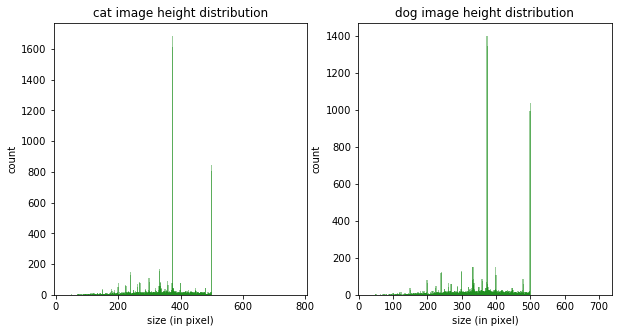

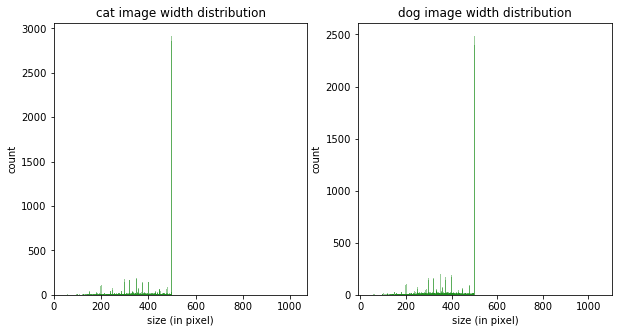

In [3]:
#data_label_list = list(temp_counter_dict.keys())
#dimension_list = list(temp_counter_dict[data_label_list[0]].keys())

        
def visualize_image_size_distribution(counter_dict):
    data_label_list = list(counter_dict.keys())
    dimension_list =   list(counter_dict[data_label_list[0]].keys())   
    for dimension in dimension_list:    
        f, ax = plt.subplots(1, 2)
        for i in range(len(data_label_list)):
            x = sorted(counter_dict[data_label_list[i]][dimension].keys())
            y = [counter_dict[data_label_list[i]][dimension][j] for j in x]
            ax[i].bar(x, y, width = 4, align='center', color= "green", alpha=0.4)            
            ax[i].set_title(data_label_list[i] + " image " + dimension + " distribution")
            ax[i].set_xlabel("size (in pixel)")
            ax[i].set_ylabel("count")
        plt.show()
        
    
            

visualize_image_size_distribution(temp_counter_dict)

    
 
    

# resize all training image to the same size

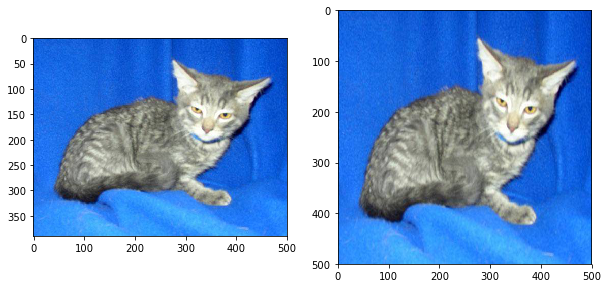

['cat', 'dog']
num of samples:  25000
['cat', 'dog']
num of samples:  25000
['cat', 'dog']
num of samples:  25000
['cat', 'dog']
num of samples:  25000
['cat', 'dog']
num of samples:  25000


In [4]:
def resize_image(image, shape = (500, 500)):
    resized_image = cv2.resize(image, shape)
    return resized_image

img = cv2.imread(data["cat"][42])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.subplot(121).imshow(img)
r = resize_image(img, (500, 500))
plt.subplot(122).imshow(r)
plt.show()


def one_hot_encoder(label_list):
    encoder = LabelEncoder()
    test = encoder.fit_transform(label_list)
    #print(test)
    #print(encoder.inverse_transform(test))
    return encoder

def sample_generator(samples, batch_size=10):
    sample_list = []
    label_list = list(samples.keys())
    print(label_list)
    
    encoder = one_hot_encoder(label_list)
    
    for label in label_list:
        for image_path in samples[label]:
            sample_list.append([label, image_path])    
    
    sample_list = shuffle(sample_list)
    num_samples = len(sample_list)
    print("num of samples: ", num_samples)
    
    
    
    while True:
        sample_list = shuffle(sample_list)
        for offset in range(0, num_samples, batch_size):
            batch_samples = sample_list[offset:offset + batch_size]
            images = []
            one_hot_labels = []
            
            for sample in batch_samples:
                image = cv2.imread(sample[1])
                image = resize_image(image)
                one_hot_label = encoder.transform([sample[0]])
                
                #plt.imshow(image)
                #plt.show()
                #print(sample[0] +  " one hot label: " , one_hot_label)
                
                images.append(image)
                one_hot_labels.append(one_hot_label)
            
            X_train = np.array(images)
            y_train = np.array(one_hot_labels)
            y_train = np_utils.to_categorical(y_train)
            #print("y_train", y_train)
            yield shuffle(X_train, y_train)
    
 

    
for i in range(5):
    next(sample_generator(data))
    

## setup model

In [9]:
def model_setup(input_shape = (500, 500, 3), num_classes = 2):
    model = Sequential()
    model.add(Convolution2D(32,3,3, dim_ordering='tf', input_shape = input_shape))    
    model.add(Activation('relu'))
    model.add(MaxPooling2D((2, 2)))
    
    model.add(Convolution2D(32,3,3))    
    model.add(Activation('relu'))
    model.add(MaxPooling2D((2, 2)))
    
    model.add(Convolution2D(64,3,3))    
    model.add(Activation('relu'))
    model.add(MaxPooling2D((2, 2)))    
    
    model.add(Flatten())
    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes))
    model.compile(loss = 'categorical_crossentropy',  optimizer="adam")
    print(model.summary())
    return model
       

model_setup()    
        
        
        
    

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_4 (Convolution2D)  (None, 498, 498, 32)  896         convolution2d_input_4[0][0]      
____________________________________________________________________________________________________
activation_2 (Activation)        (None, 498, 498, 32)  0           convolution2d_4[0][0]            
____________________________________________________________________________________________________
maxpooling2d_2 (MaxPooling2D)    (None, 249, 249, 32)  0           activation_2[0][0]               
____________________________________________________________________________________________________
convolution2d_5 (Convolution2D)  (None, 247, 247, 32)  9248        maxpooling2d_2[0][0]             
___________________________________________________________________________________________

In [ ]:
def flow_setup():
    sample_dict = load_data(TRAIN_DATA_PATH_LIST)  